In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=17WwtkoQXmh-aakunX52RTTADaZ2OAw9K' # The shareable link
fluff, id = link.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ASX200Monthly.csv')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

In [0]:
# Reading data
monthly_data = pd.read_csv('ASX200Monthly.csv')

In [10]:
# Converting to a time series
monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])
monthly_data.set_index('Date', inplace = True)
monthly_ts = pd.Series(monthly_data['Close'])
print(monthly_ts.head())

Date
2000-02-29            NaN
2000-03-31    3115.800049
2000-04-30    3081.000000
2000-05-31    3311.199951
2000-06-30    3251.100098
Name: Close, dtype: float64


In [0]:
# Removing missing values
monthly_ts.dropna(inplace=True)

In [0]:
# Transforming time series by taking log. 
# It reduces variation in data by penalizing larger values more than the smaller ones 
monthly_ts = np.log(monthly_ts)

In [0]:
# Splitting data into training and validation subsets
training_subset = monthly_ts[:-12]
validation_subset = monthly_ts[-12:]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


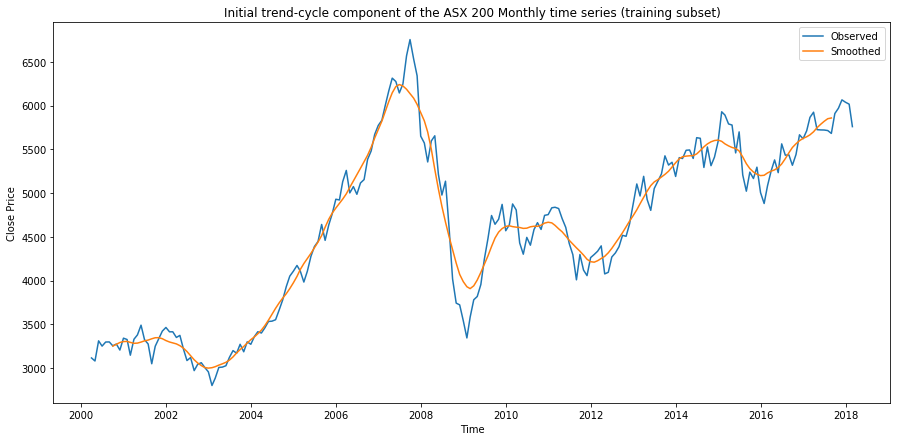

In [13]:
# Smoothing data by using CMA-12 to calculate the initial trend-cycle estimate
trend_cycle = training_subset.rolling(2, center=True).mean().rolling(12, center=True).mean().shift(-1)

# Setting figure width and height
rcParams['figure.figsize'] = 15, 7

plt.plot(training_subset, label = "Observed")
plt.plot(trend_cycle, label = "Smoothed")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Initial trend-cycle component of the ASX 200 Monthly time series (training subset)')
plt.legend()

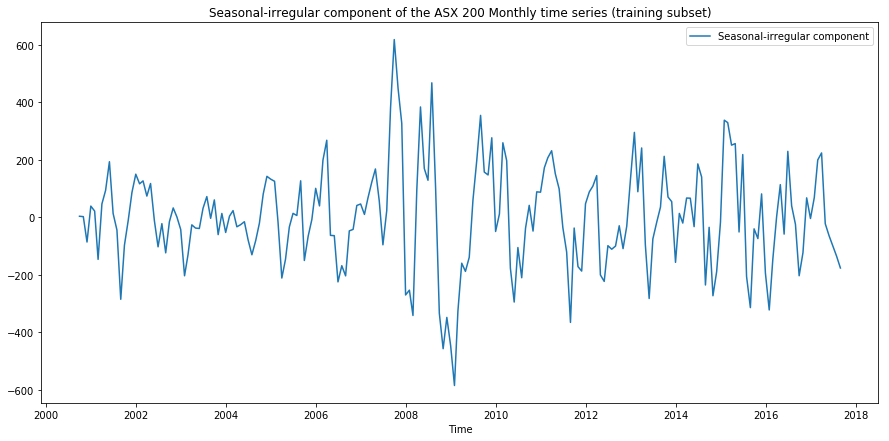

In [14]:
# Calculating the seasonal-irregular component
seasonal = training_subset - trend_cycle

plt.plot(seasonal, label = "Seasonal-irregular component")
plt.xlabel('Time')
plt.title('Seasonal-irregular component of the ASX 200 Monthly time series (training subset)')
plt.legend()

In [15]:
# Calculating (un-normalized) seasonal indexes
seasonal_indexes = np.empty(12)
for i in range(0,12):
    seasonal_indexes[i] = seasonal[seasonal.index.month==i+1].mean()

seasonal_indexes

array([ -3.59976432,  28.14851706,  90.0083498 ,  23.16696349,
       -46.51105522,  -2.19067563, -13.00219007, -56.17305199,
         4.83902219, -38.38237923,  19.36593631, -29.17677699])

In [16]:
# Calculating normalized seasonal indexes
norm_seasonal_indexes = seasonal_indexes - seasonal_indexes.mean()
norm_seasonal_indexes

array([ -1.64083893,  30.10744244,  91.96727519,  25.12588887,
       -44.55212984,  -0.23175025, -11.04326469, -54.21412661,
         6.79794757, -36.42345385,  21.32486169, -27.2178516 ])

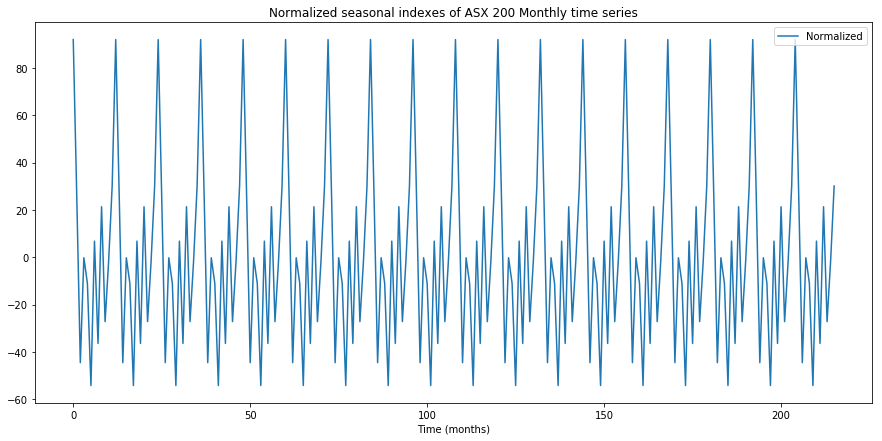

In [17]:
# Repeating normalized seasonal indexes for the entire duration
seasonal_components = np.empty(training_subset.size)
for i in range(0,training_subset.size):
    seasonal_components[i] = norm_seasonal_indexes[seasonal.index.month[i]-1]

plt.plot(seasonal_components, label = "Normalized")
plt.xlabel('Time (months)')
plt.title('Normalized seasonal indexes of ASX 200 Monthly time series')
plt.legend()

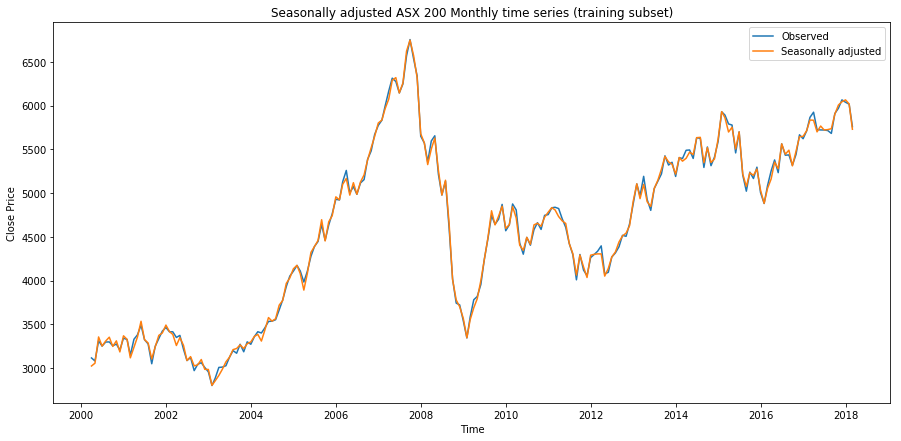

In [18]:
# Calculating seasonally adjusted series
seasonally_adjusted = training_subset - seasonal_components

plt.plot(training_subset, label = "Observed")
plt.plot(seasonally_adjusted, label = "Seasonally adjusted")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Seasonally adjusted ASX 200 Monthly time series (training subset)')
plt.legend()

In [22]:
# Dataframe for linear regression
monthly_df = pd.DataFrame()
monthly_df['Time'] = range(1, training_subset.size+1)
monthly_df['Close'] = seasonally_adjusted.values
monthly_df.head()

,Time,Close
0,1,3023.832774
1,2,3055.874111
2,3,3355.752081
3,4,3251.331848
4,5,3308.843314


In [23]:
# Creating a linear regression model
lm = LinearRegression()
lm.fit(monthly_df[['Time']], monthly_df[['Close']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
# Coefficient and intercept values
coef = lm.coef_[0][0]
intercept = lm.intercept_[0]
print('Coefficient:', coef)
print('Intercept:', intercept)

Coefficient: 11.546826822801886
Intercept: 3330.3577233463657


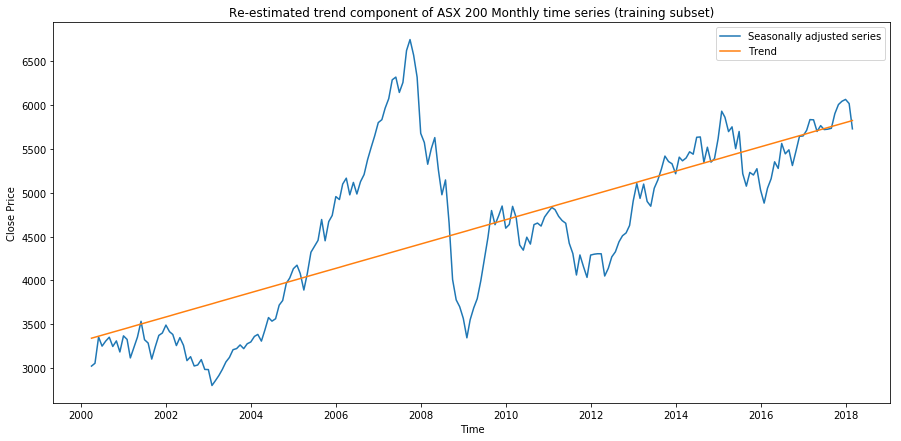

In [26]:
# Re-estimating trend
reestimated_trend = pd.Series(data=(intercept + monthly_df['Time']*coef).values, index=seasonally_adjusted.index)

plt.plot(seasonally_adjusted, label = "Seasonally adjusted series")
plt.plot(reestimated_trend, label = "Trend")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Re-estimated trend component of ASX 200 Monthly time series (training subset)')
plt.legend()

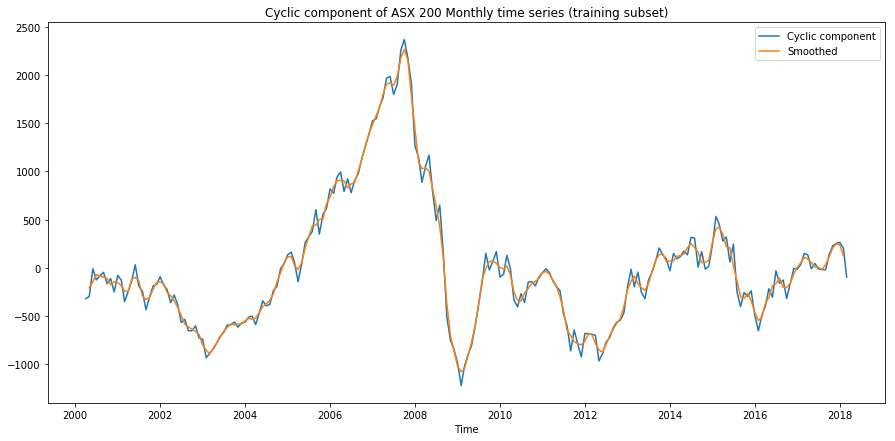

In [27]:
# Estimating cyclic component
trend_seasonal = reestimated_trend + seasonal_components
cyclic_component = training_subset - trend_seasonal

# Removing noise by smoothing data (MA-3)
cyclic = cyclic_component.rolling(3, center=True).mean()

plt.plot(cyclic_component, label = "Cyclic component")
plt.plot(cyclic, label = "Smoothed")
plt.xlabel('Time')
plt.title('Cyclic component of ASX 200 Monthly time series (training subset)')
plt.legend()

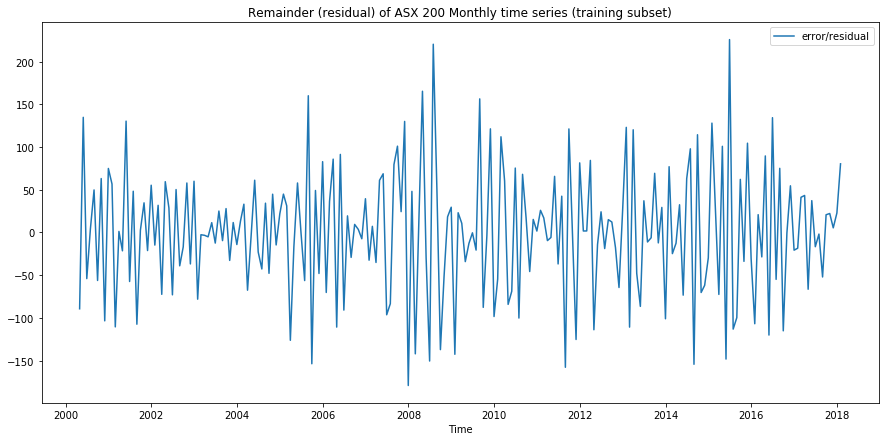

In [28]:
# Calculating remainder
remainder = training_subset - (cyclic + reestimated_trend + seasonal_components)

plt.plot(remainder, label = "error/residual")
plt.xlabel('Time')
plt.title('Remainder (residual) of ASX 200 Monthly time series (training subset)')
plt.legend()

In [0]:
# Forecasting 'Close' price for next 12 months (validation subset)

training_ts = reestimated_trend + seasonal_components

t = np.empty(validation_subset.size)
for i in range(0,validation_subset.size):
    t[i] = intercept + (training_subset.size+1+i)*coef

seasonal = monthly_ts - trend_cycle
seasonal_components = np.empty(monthly_ts.size)
for i in range(0,monthly_ts.size):
    seasonal_components[i] = norm_seasonal_indexes[seasonal.index.month[i]-1]

predictions = validation_subset.copy()
for i in range(0,predictions.size):
    predictions[i] = t[i] + seasonal_components[training_subset.size+i]

In [0]:
# Appending fitted values with the predicted values
predicted_ts = training_ts.append(predictions)

In [0]:
# Returning data to its original form by taking inverse of log
predicted_ts = np.exp(predicted_ts)
monthly_ts = np.exp(monthly_ts)
training_subset = np.exp(training_subset)
training_ts = np.exp(training_ts)
validation_subset = np.exp(validation_subset)
predictions = np.exp(predictions)

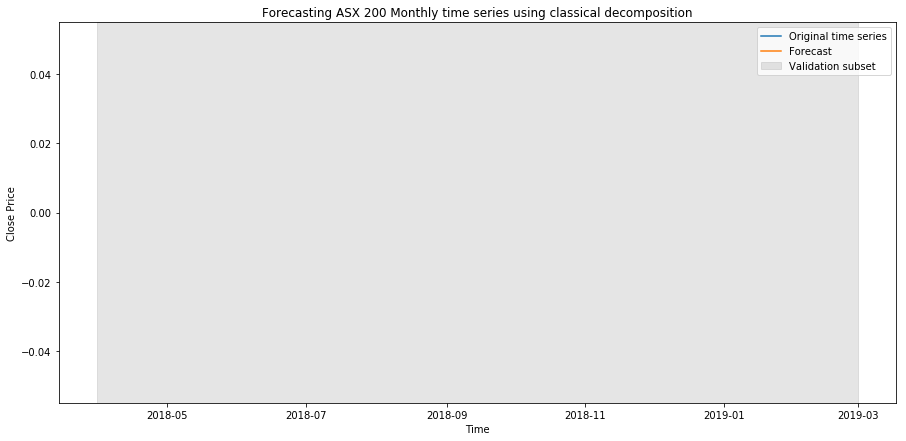

In [35]:
plt.plot(monthly_ts, label = "Original time series")
plt.plot(predicted_ts, label = "Forecast")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Forecasting ASX 200 Monthly time series using classical decomposition')
plt.legend()

In [0]:
# Measuring errors of training subset
RMSE = np.sqrt(mean_squared_error(training_subset, training_ts))
MAE = mean_absolute_error(training_subset, training_ts)
MAPE = np.mean(np.abs((training_subset - training_ts) / training_subset)) * 100

print('Training subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset ->
Root Mean Squared Error (RMSE): 689.6063657411074
Mean Absolute Error (MAE): 478.0980761170657
Mean Absolute Percentage Error (MAPE): 10.4309522132754


In [0]:
# Measuring errors of validation subset
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions))
MAE = mean_absolute_error(validation_subset, predictions)
MAPE = np.mean(np.abs((validation_subset - predictions) / validation_subset)) * 100

print('Validation subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset ->
Root Mean Squared Error (RMSE): 258.61520462687054
Mean Absolute Error (MAE): 219.14960338555997
Mean Absolute Percentage Error (MAPE): 3.696469409637674
